# Table of Contents
<a id="top"></a>

1. [Completion time boxplots](#tcompl)

    1.1 [Diffusion and attraction radius](#drboxplots)
    
    1.2 [Model comparison](#modelboxplots)
    
    
2. [KDE plots](#kde)

    2.1 [Individual origin efficiency](#indeff)
    
    2.2 [Average origin efficiency](#avgeff)
    
    2.3 [Individual activation time](#indact)
    
    2.4 [Average activation time](#avgact)
    
    
3. [Sensitivity analysis](#sens)


4. [Replication kinetics](#kinetics)

    4.1 [Origin states](#oristates)
    
    4.2 [Bound and free factors](#bound)
    
    4.3 [Replication rate](#rate)
    
    4.4 [I(t)](#it)


5. [Firing concurrence](#cmatrix)

    5.1 [High binding probability](#hibind)
    
    5.2 [Low binding probability](#lobind)

In [12]:
import linecache
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import scipy.interpolate as interpolate
import scipy.integrate as integrate
import seaborn as sns
import os, re
from matplotlib.colors import LinearSegmentedColormap

# basedir should contain Analysis, Data, Simulations i.e. Summer 2018 on Box
basedir = r'..'
# where plots will be saved
savedir = r'./Figures/Final'

In [13]:
vFork = 50

def oriNameToIndex(name):
    return int(name[-3:]) - 1

def oriIndexToName(index):
    return 'ORI' + "%03d" % (index + 1)

# Load data from the output of runbatch
def loadBatchSimulationInput(toriFile, line):
    firingEvents = []
    firingTimes = linecache.getline(toriFile, line).split(',')[2:]
    originNames = linecache.getline(toriFile, 1).split(',')[2:]
    for i in range(len(firingTimes)):
        if float(firingTimes[i]) != 0:
            firingEvents.append({
                'TIME': float(firingTimes[i]),
                'ORI': oriIndexToName(i)
            })
    return firingEvents

def getSimkey(n, d=False, r=False, b=False, a=False):
    simkey = 'SIM_N' + str(n)
    if d:
        simkey += '_D' + str(d)
    if r:
        simkey += '_R' + str(r)
    if b:
        simkey += '_B' + str(b)
    if a:
        simkey += '_A' + str(a)
    return simkey

# Completion Times
<a id="tcompl"></a>
##### (Figure 2)

Boxplots showing completion times for different number of activation factors, comparing diffusion, radius of attraction, and three different models. 

[Return to top](#top)

In [14]:
def loadCompletionTimes(tcomplFile):
    return np.genfromtxt(tcomplFile, delimiter=',')[1:, 2]

### Diffusion and attraction radius
<a id="drboxplots"></a>

[Return to top](#top)

In [15]:
outDir = basedir + r'/Simulations/runA_spb/out/'
params = {
    'N': ['150', '200', '400'],
    'D': ['0.5', '2.0', '3.5'],
    'R': ['0.015', '0.025', '0.035'],
    'pBind': [1],
    'pAct': [1]
}
simDataD = pd.DataFrame({'N': [], 'D': [], 'TIME': []})
for i, n in enumerate(params['N']):
    for j, d in enumerate(params['D']):
        for r in params['R']:
            tcomplFile = outDir + 'SIM_N' + n + '_D' + d + '_R' + r + '_P1_A1_completionTimes.csv'
            completionTimes = loadCompletionTimes(tcomplFile)
            simDataD = simDataD.append(pd.DataFrame({'N': [n for i in completionTimes],
                                          'D': [d for i in completionTimes],
                                          'TIME': (completionTimes / 60).tolist()}))
simDataR = pd.DataFrame({'N': [], 'R': [], 'TIME': []})
for i, n in enumerate(params['N']):
    for j, r in enumerate(params['R']):
        for d in params['D']:
            tcomplFile = outDir + 'SIM_N' + n + '_D' + d + '_R' + r + '_P1_A1_completionTimes.csv'
            completionTimes = loadCompletionTimes(tcomplFile)
            simDataR = simDataR.append(pd.DataFrame({'N': [n for i in completionTimes],
                                          'R': [r for i in completionTimes],
                                          'TIME': (completionTimes / 60).tolist()}))

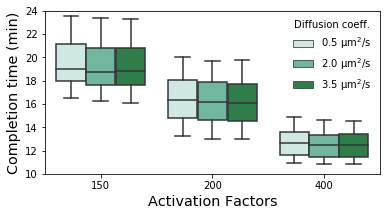

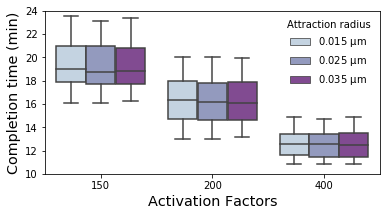

In [16]:
# Diffusion coefficient boxplots
plotFile = savedir + r'/completion-diffusion.pdf'
ax = plt.figure(figsize=(6,3)).gca()
g = sns.boxplot(x='N', y='TIME', hue='D',data=simDataD, palette='BuGn')
new_title = 'Diffusion coeff.'
g.legend_.set_title(new_title)
g.legend_.set_frame_on(False)
new_labels = ['0.5 $\mathrm{\mu m^2/s}$', '2.0 $\mathrm{\mu m^2/s}$', '3.5 $\mathrm{\mu m^2/s}$']
for t, l in zip(g.legend_.texts, new_labels): t.set_text(l)
ax.set_ylim(10, 24)
ax.set_xlabel('Activation Factors', size='x-large')
ax.set_ylabel('Completion time (min)', size='x-large')
plt.savefig(plotFile, bbox_inches='tight')
plt.show()

# Attraction radius boxplots
plotFile = savedir + r'/completion-radius.pdf'
ax = plt.figure(figsize=(6,3)).gca()
g = sns.boxplot(x='N', y='TIME', hue='R',data=simDataR, palette='BuPu')
new_title = 'Attraction radius'
g.legend_.set_title(new_title)
g.legend_.set_frame_on(False)
new_labels = ['0.015 $\mathrm{\mu m}$', '0.025 $\mathrm{\mu m}$', '0.035 $\mathrm{\mu m}$']
for t, l in zip(g.legend_.texts, new_labels): t.set_text(l)
ax.set_ylim(10, 24)
ax.set_xlabel('Activation Factors', size='x-large')
ax.set_ylabel('Completion time (min)', size='x-large')
plt.savefig(plotFile, bbox_inches='tight')
plt.show()

### Model comparison
<a id="modelboxplots"></a>

[Return to top](#top)

In [17]:
ranDir = basedir + r'/Simulations/runA_ran/out/'
uniDir = basedir + r'/Simulations/runA_uni/out/'
spbDir = basedir + r'/Simulations/runA_spb/out/'

params = {
    'N': [50, 100, 150, 200, 400, 600, 800, 1000],
    #'D': ['0.5', '2.0', '3.5'],
    #'R': ['0.015', '0.025', '0.035']
    'D': ['0.5'],
    'R': ['0.025']
}
simData = pd.DataFrame({'N': [], 'VAR': [], 'TIME': []})
for i, n in enumerate(params['N']):
    for d in params['D']:
        for r in params['R']:
            tcomplFile = spbDir + 'SIM_N' + str(n) + '_D' + d + '_R' + r + '_P1_A1_completionTimes.csv'
            completionTimes = loadCompletionTimes(tcomplFile)
            simData = simData.append(pd.DataFrame({'N': [int(n) for i in completionTimes],
                                          'VAR': ['spb' for i in completionTimes],
                                          'TIME': (completionTimes / 60).tolist()}))
            tcomplFile = uniDir + 'SIM_N' + str(n) + '_D' + d + '_R' + r + '_P1_completionTimes.csv'
            completionTimes = loadCompletionTimes(tcomplFile)
            simData = simData.append(pd.DataFrame({'N': [int(n) for i in completionTimes],
                                          'VAR': ['uni' for i in completionTimes],
                                          'TIME': (completionTimes / 60).tolist()}))
            tcomplFile = ranDir + 'SIM_N' + str(n) + '_D' + d + '_R' + r + '_P1_completionTimes.csv'
            completionTimes = loadCompletionTimes(tcomplFile)
            simData = simData.append(pd.DataFrame({'N': [int(n) for i in completionTimes],
                                          'VAR': ['ran' for i in completionTimes],
                                          'TIME': (completionTimes / 60).tolist()}))

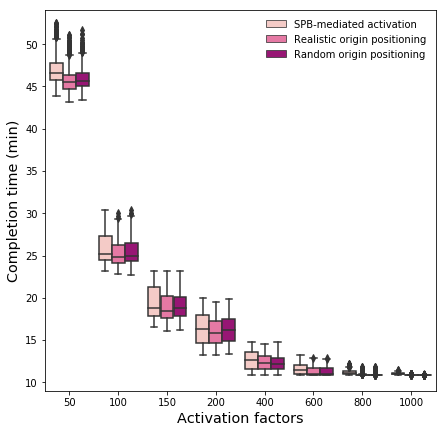

In [18]:
plotFile = savedir + r'/completion-model-variants.pdf'
ax = plt.figure(figsize=(7,7)).gca()
g = sns.boxplot(x='N', y='TIME', hue='VAR',data=simData, palette='RdPu')
# title
new_title = 'Model variant'
g.legend_.set_title(None)
g.legend_.set_frame_on(False)
# replace labels
new_labels = ['SPB-mediated activation', 'Realistic origin positioning', 'Random origin positioning']
for t, l in zip(g.legend_.texts, new_labels): t.set_text(l)

ax.set_xlabel('Activation factors', size='x-large')
ax.set_ylabel('Completion time (min)', size='x-large')
ax.set_xticklabels(params['N'])
ax.set_ylim(9, 54)
plt.savefig(plotFile, bbox_inches='tight')
plt.show()

# KDE plots
<a id="kde"></a>

KDE plots of origins in the nucleus. Showing high, intermediate, and low efficiencies, as well as early, intermediate, and late firing times.

<b>"Individual" versus "average"</b>: Simulations were repeated several times for each structure. Individual efficiencies and firing times are calculated by averaging only simulations with the same structure. Average efficiencies and firing times are calculated from all simulation runs, so each origin is considered to have the same average efficiency for all structures. "Individual" best illustrates the model and is most representative of what would happen in a single simulation / DNA replication. "Average" is most representative of the kind of results one would get from experiment. Hence only average has the comparison to experimental results from Heichinger / Lygeros.

[Return to top](#top)

In [19]:
def inDomain(x, r):
    return (x**2 + r**2 <= 1.33**2) and ((x-1.51)**2 + r**2 > 1.33**2)

def rotationallyNormalize(dataX, dataY, dataZ):
    return (np.array(dataX), np.array(np.sqrt(dataY**2 + dataZ**2)))

def params2simkey(n, d, p, b):
    return 'SIM_N{0:03d}_D{1:0.1f}_P{2:0.1f}_B{3:0.3f}'.format(int(n), float(d), float(p), float(b))

def simkey2params(simkey):
    params = simkey.split('_')
    n = int(params[1][1:])
    d = float(params[2][1:])
    p = float(params[3][1:])
    b = float(params[4][1:])
    return (n, d, p, b)

def readOrieff(file):
    df = pd.read_csv(file, names=['CHR', 'POS', 'EFF_EXP'])
    df.insert(2, 'GID', (df.POS / 3500).astype(int))
    return df

def readOritact(file):
    df = pd.read_csv(file, names=['CHR', 'POS', 'TACT'])
    df.insert(2, 'GID', (df.POS / 3500).astype(int))
    return df

def readOripos(file):
    df = pd.read_csv(file, names=['ORI', 'CHR', 'POS'])
    df.insert(3, 'GID', (df.POS / 3500).astype(int))
    return df

def readStruct(file):
    df = pd.read_csv(file, names=['CHR', 'POSX', 'POSY', 'POSZ'])
    df.insert(1, 'GID', 0)
    for x in df.CHR.unique():
        df.loc[df.CHR == x, 'GID'] = list(range(sum(df.CHR == x)))
    return df

def readSimulationData(outDir, outFilePattern):
    simulationData = []
    regex = re.compile(outFilePattern)
    for file in filter(regex.match, os.listdir(outDir)):
        df = pd.read_csv(os.path.join(outDir, file))
        (n, d, p, b) = simkey2params(file)
        df.insert(0, 'N', n)
        df.insert(1, 'D', d)
        df.insert(2, 'P', p)
        df.insert(3, 'B', b)
        simulationData.append(df)
    simulationData = pd.concat(simulationData, ignore_index=True, copy=False)
    simulationData.sort_values(['N', 'D', 'P', 'B', 'STRUCTURE', 'ITERATION'], inplace=True)
    simulationData.reset_index(drop=True, inplace=True)
    return simulationData

def loadExperimentalKDEData(structDir, orieffFile, oriposFile, oritactFile=False):
    data = []
    originPositions = readOripos(oriposFile)
    obsEfficiencies = readOrieff(orieffFile)
    if oritactFile:
        originTacts = readOritact(oritactFile)
    for structFile in os.listdir(structDir):
        granulePositions = readStruct(os.path.join(structDir, structFile))
        df = originPositions.merge(granulePositions, on=['CHR', 'GID'], copy=False)
        df = df.merge(obsEfficiencies, on=['CHR', 'POS', 'GID'])
        if oritactFile:
            df = df.merge(originTacts, on=['CHR', 'POS', 'GID'])
        df.insert(0, 'STRUCTURE', structFile)
        data.append(df)
    return pd.concat(data, ignore_index=True, copy=False)

def loadSimulatedKDEData(structDir, orieffFile, oriposFile, outDir, outFilePattern):
    data = []
    obsEfficiencies = readOrieff(orieffFile)
    originPositions = readOripos(oriposFile)
    simulationData = readSimulationData(outDir, outFilePattern)
    for structFile, structGroup in simulationData.groupby('STRUCTURE'):
        structGroupOriInfo = structGroup.iloc[:, 6:]
        granulePositions = readStruct(os.path.join(structDir, structFile))
        simEfficiencies = (structGroupOriInfo > 0).mean().rename('EFF_SIM').to_frame()
        simActivationTimes = (structGroupOriInfo.sum() / (structGroupOriInfo > 0).sum()).rename('TACT_SIM').to_frame()
        df = originPositions.merge(granulePositions, on=['CHR', 'GID'], copy=False)
        df = df.merge(obsEfficiencies, on=['CHR', 'POS', 'GID'])
        df = df.merge(simEfficiencies, left_on='ORI', right_index=True, copy=False)
        df = df.merge(simActivationTimes, left_on='ORI', right_index=True, copy=False)
        df.insert(0, 'STRUCTURE', structFile)
        data.append(df)
    return pd.concat(data, ignore_index=True, copy=False)

def loadAverageSimulatedKDEData(structDir, orieffFile, oriposFile, outDir, outFilePattern):
    data = []
    obsEfficiencies = readOrieff(orieffFile)
    originPositions = readOripos(oriposFile)
    simulationData = readSimulationData(outDir, outFilePattern)
    allOriInfo = simulationData.iloc[:, 6:]
    avgEfficiencies = (allOriInfo > 0).mean().rename('EFF_SIM').to_frame()
    avgActivationTimes = (allOriInfo.sum() / (allOriInfo > 0).sum()).rename('TACT_SIM').to_frame()
    for structFile, structGroup in simulationData.groupby('STRUCTURE'):
        granulePositions = readStruct(os.path.join(structDir, structFile))
        df = originPositions.merge(granulePositions, on=['CHR', 'GID'], copy=False)
        df = df.merge(obsEfficiencies, on=['CHR', 'POS', 'GID'])
        df = df.merge(avgEfficiencies, left_on='ORI', right_index=True, copy=False)
        df = df.merge(avgActivationTimes, left_on='ORI', right_index=True, copy=False)
        df.insert(0, 'STRUCTURE', structFile)
        data.append(df)
    return pd.concat(data, ignore_index=True, copy=False)

def computeRadialKDE(x, r, dataX, dataR, bw):
    dist2 = (dataX - x) ** 2 + (dataR - r) ** 2
    kernel2D = np.exp(-0.5 * dist2 / (bw ** 2)) / (2 * np.pi * (bw ** 2))
    return np.mean(kernel2D, dtype=np.float64) / (2 * np.pi * abs(r))
            
def plotRadialKDE(ax, radialKDE, vmin, vmax, colormap):
    ax.set_xlabel('x')
    ax.set_ylabel('r')
    ax.set_xlim(-5, 271)
    ax.set_ylim(-5, 271)
    mirroredRadialKDE = np.concatenate((radialKDE[::-1], radialKDE))
    width = mirroredRadialKDE.shape[0] # 266
    ax.imshow(mirroredRadialKDE, aspect='equal', interpolation='none', origin='lower', vmin=vmin, vmax=vmax, cmap=colormap)
    circle1=plt.Circle((width / 2, width / 2), width / 2, fill=False, linewidth=2)
    ax.add_artist(circle1)
    arc=patches.Arc((151 + width / 2, width / 2), width, width, theta1=125, theta2=235, linewidth=1.5, linestyle='--')
    ax.add_patch(arc)
    ax.plot((0, width), (width / 2, width / 2), 'k--')
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    ax.axis('off')
    
def customWhiteColormap(r, g, b, bins): # color map with white and another color
    colors = [(1, 1, 1), (r, g, b)]
    return LinearSegmentedColormap.from_list('custom_colormap', colors, N=bins)

def customColormap(colors, bins):
    return LinearSegmentedColormap.from_list('custom_colormap', colors, N=bins)

# Colors
cmap_green = customColormap([(1, 1, 1), (102/256,194/256,164/256), (0,109/256,44/256)], 200)
cmap_orange = customColormap([(1, 1, 1), (252/256,141/256,89/256), (179/256, 0, 0)], 200)
cmap_purple = customColormap([(1, 1, 1), (140/256,150/256,198/256), (129/256,15/256,124/256)], 200)

## Structure-averaged efficiencies (i.e. "individual" efficiencies)
<a id="indeff"></a>
(Supplement)

[Return to top](#top)

In [25]:
from threading import Thread
import matplotlib.image as mpimg

bw = 0.015
delta = 0.01

ranData = loadSimulatedKDEData(basedir + r'/Data/G1_constraint_100',
                               basedir + r'/Data/orieff_heichinger.csv',
                               basedir + r'/Data/oripos_heichinger.csv',
                               basedir + r'/Simulations/runA_ran/out', r'.*_firingTimes\.csv')

uniData = loadSimulatedKDEData(basedir + r'/Data/G1_grand_eve',
                               basedir + r'/Data/orieff_heichinger.csv',
                               basedir + r'/Data/oripos_heichinger.csv',
                               basedir + r'/Simulations/runA_uni/out', r'.*_firingTimes\.csv')

spbData = loadSimulatedKDEData(basedir + r'/Data/G1_grand_eve',
                               basedir + r'/Data/orieff_heichinger.csv',
                               basedir + r'/Data/oripos_heichinger.csv',
                               basedir + r'/Simulations/runA_spb/out', r'.*_firingTimes\.csv')

effResults = {}
plotX = np.arange(-1.33 + delta/2, 1.33 + delta/2, delta)
plotR = np.arange(0 + delta/2, 1.33 + delta/2, delta)

ranDataX, ranDataR = rotationallyNormalize(ranData.POSX, ranData.POSY, ranData.POSZ)
uniDataX, uniDataR = rotationallyNormalize(uniData.POSX, uniData.POSY, uniData.POSZ)
spbDataX, spbDataR = rotationallyNormalize(spbData.POSX, spbData.POSY, spbData.POSZ)

def runAll():
    ranRadialKDE = np.array([[computeRadialKDE(x, r, ranDataX, ranDataR, bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    uniRadialKDE = np.array([[computeRadialKDE(x, r, uniDataX, uniDataR, bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    spbRadialKDE = np.array([[computeRadialKDE(x, r, spbDataX, spbDataR, bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    effResults['ALL'] = {'ranRadialKDE': ranRadialKDE, 'uniRadialKDE': uniRadialKDE, 'spbRadialKDE': spbRadialKDE}

def runLow():
    ranMask = np.array(ranData.EFF_SIM < ranData.EFF_SIM.quantile(0.25), dtype=bool)
    uniMask = np.array(uniData.EFF_SIM < uniData.EFF_SIM.quantile(0.25), dtype=bool)
    spbMask = np.array(spbData.EFF_SIM < spbData.EFF_SIM.quantile(0.25), dtype=bool)
    ranRadialKDE = np.array([[computeRadialKDE(x, r, ranDataX[ranMask], ranDataR[ranMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    uniRadialKDE = np.array([[computeRadialKDE(x, r, uniDataX[uniMask], uniDataR[uniMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    spbRadialKDE = np.array([[computeRadialKDE(x, r, spbDataX[spbMask], spbDataR[spbMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    effResults['LOW'] = {'ranRadialKDE': ranRadialKDE, 'uniRadialKDE': uniRadialKDE, 'spbRadialKDE': spbRadialKDE}

def runMedium():
    ranMask = np.array((ranData.EFF_SIM >= ranData.EFF_SIM.quantile(0.25)) & (ranData.EFF_SIM <= ranData.EFF_SIM.quantile(0.75)), dtype=bool)
    uniMask = np.array((uniData.EFF_SIM >= uniData.EFF_SIM.quantile(0.25)) & (uniData.EFF_SIM <= uniData.EFF_SIM.quantile(0.75)), dtype=bool)
    spbMask = np.array((spbData.EFF_SIM >= spbData.EFF_SIM.quantile(0.25)) & (spbData.EFF_SIM <= spbData.EFF_SIM.quantile(0.75)), dtype=bool)
    ranRadialKDE = np.array([[computeRadialKDE(x, r, ranDataX[ranMask], ranDataR[ranMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    uniRadialKDE = np.array([[computeRadialKDE(x, r, uniDataX[uniMask], uniDataR[uniMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    spbRadialKDE = np.array([[computeRadialKDE(x, r, spbDataX[spbMask], spbDataR[spbMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    effResults['MEDIUM'] = {'ranRadialKDE': ranRadialKDE, 'uniRadialKDE': uniRadialKDE, 'spbRadialKDE': spbRadialKDE}

def runHigh():    
    ranMask = np.array(ranData.EFF_SIM > ranData.EFF_SIM.quantile(0.75), dtype=bool)
    uniMask = np.array(uniData.EFF_SIM > uniData.EFF_SIM.quantile(0.75), dtype=bool)
    spbMask = np.array(spbData.EFF_SIM > spbData.EFF_SIM.quantile(0.75), dtype=bool)
    ranRadialKDE = np.array([[computeRadialKDE(x, r, ranDataX[ranMask], ranDataR[ranMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    uniRadialKDE = np.array([[computeRadialKDE(x, r, uniDataX[uniMask], uniDataR[uniMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    spbRadialKDE = np.array([[computeRadialKDE(x, r, spbDataX[spbMask], spbDataR[spbMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    effResults['HIGH'] = {'ranRadialKDE': ranRadialKDE, 'uniRadialKDE': uniRadialKDE, 'spbRadialKDE': spbRadialKDE}

threadAll = Thread(target=runAll)
threadLow = Thread(target=runLow)
threadMedium = Thread(target=runMedium)
threadHigh = Thread(target=runHigh)

threadAll.start()
threadLow.start() 
threadMedium.start()
threadHigh.start()

threadAll.join()
threadLow.join()
threadMedium.join()
threadHigh.join()

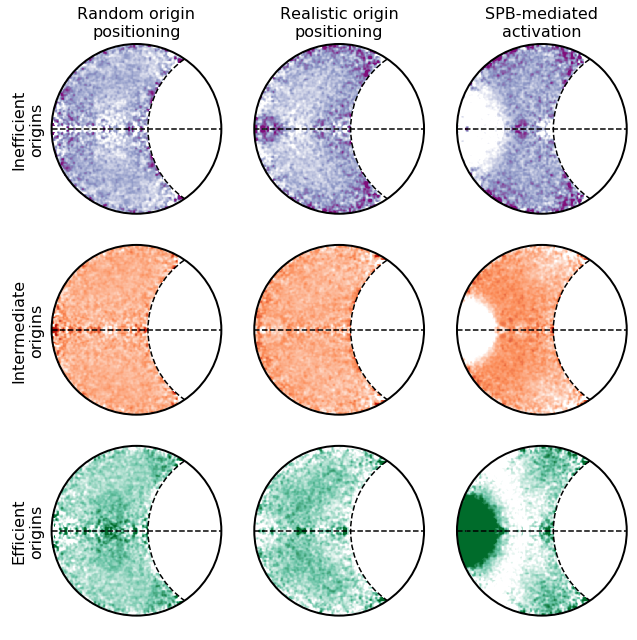

In [26]:
plotFile = savedir + r'/individual-efficiency-kde.pdf'
vmin = 0.5
vmax = 2

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(3*3, 3*3))
colTitles = ['Random origin\npositioning', 'Realistic origin\npositioning', 'SPB-mediated\nactivation']
for ax, colTitle in zip(axes[0, :], colTitles):
    ax.annotate(colTitle, xy=(0.5, 1), xytext=(0, 5), xycoords='axes fraction', textcoords='offset points', size=16, ha='center', va='baseline')
rowTitles = ['Inefficient\norigins', 'Intermediate\norigins', 'Efficient\norigins']
for ax, rowTitle in zip(axes[:, 0], rowTitles):
    ax.annotate(rowTitle, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 7, 0), xycoords=ax.yaxis.label, textcoords='offset points', size=16, ha='center', va='center', rotation=90)
    
def plotRow(axrow, key, cmap):
    ranRelRadialKDE = effResults[key]['ranRadialKDE'] / (effResults['ALL']['ranRadialKDE'] + np.finfo(np.float64).eps)
    uniRelRadialKDE = effResults[key]['uniRadialKDE'] / (effResults['ALL']['uniRadialKDE'] + np.finfo(np.float64).eps)
    spbRelRadialKDE = effResults[key]['spbRadialKDE'] / (effResults['ALL']['spbRadialKDE'] + np.finfo(np.float64).eps)
    plotRadialKDE(axrow[0], ranRelRadialKDE, vmin, vmax, cmap)
    plotRadialKDE(axrow[1], uniRelRadialKDE, vmin, vmax, cmap)
    plotRadialKDE(axrow[2], spbRelRadialKDE, vmin, vmax, cmap)
    
plotRow(axes[0, :], 'LOW', cmap_purple)
plotRow(axes[1, :], 'MEDIUM', cmap_orange)
plotRow(axes[2, :], 'HIGH', cmap_green)

plt.tight_layout()
plt.savefig(plotFile, bbox_inches='tight')
plt.show()

## Origin-averaged efficiencies (i.e. "average")
<a id="avgeff"></a>

[Return to top](#top)

In [27]:
from threading import Thread
import matplotlib.image as mpimg

bw = 0.015
delta = 0.01

expData = loadExperimentalKDEData(basedir + r'/Data/G1_grand_eve',
                                  basedir + r'/Data/orieff_heichinger.csv',
                                  basedir + r'/Data/oripos_heichinger.csv')

ranData = loadAverageSimulatedKDEData(basedir + r'/Data/G1_constraint_100',
                                      basedir + r'/Data/orieff_heichinger.csv',
                                      basedir + r'/Data/oripos_heichinger.csv',
                                      basedir + r'/Simulations/runA_ran/out', r'.*_firingTimes\.csv')

uniData = loadAverageSimulatedKDEData(basedir + r'/Data/G1_grand_eve',
                                      basedir + r'/Data/orieff_heichinger.csv',
                                      basedir + r'/Data/oripos_heichinger.csv',
                                      basedir + r'/Simulations/runA_uni/out', r'.*_firingTimes\.csv')

spbData = loadAverageSimulatedKDEData(basedir + r'/Data/G1_grand_eve',
                                      basedir + r'/Data/orieff_heichinger.csv',
                                      basedir + r'/Data/oripos_heichinger.csv',
                                      basedir + r'/Simulations/runA_spb/out', r'.*_firingTimes\.csv')

effResults = {}
plotX = np.arange(-1.33 + delta/2, 1.33 + delta/2, delta)
plotR = np.arange(0 + delta/2, 1.33 + delta/2, delta)

expDataX, expDataR = rotationallyNormalize(expData.POSX, expData.POSY, expData.POSZ)
ranDataX, ranDataR = rotationallyNormalize(ranData.POSX, ranData.POSY, ranData.POSZ)
uniDataX, uniDataR = rotationallyNormalize(uniData.POSX, uniData.POSY, uniData.POSZ)
spbDataX, spbDataR = rotationallyNormalize(spbData.POSX, spbData.POSY, spbData.POSZ)

def runAll():
    expRadialKDE = np.array([[computeRadialKDE(x, r, expDataX, expDataR, bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    ranRadialKDE = np.array([[computeRadialKDE(x, r, ranDataX, ranDataR, bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    uniRadialKDE = np.array([[computeRadialKDE(x, r, uniDataX, uniDataR, bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    spbRadialKDE = np.array([[computeRadialKDE(x, r, spbDataX, spbDataR, bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    effResults['ALL'] = {'expRadialKDE': expRadialKDE, 'ranRadialKDE': ranRadialKDE, 'uniRadialKDE': uniRadialKDE, 'spbRadialKDE': spbRadialKDE}

def runLow():
    expMask = np.array(expData.EFF_EXP < expData.EFF_EXP.quantile(0.25), dtype=bool)
    ranMask = np.array(ranData.EFF_SIM < ranData.EFF_SIM.quantile(0.25), dtype=bool)
    uniMask = np.array(uniData.EFF_SIM < uniData.EFF_SIM.quantile(0.25), dtype=bool)
    spbMask = np.array(spbData.EFF_SIM < spbData.EFF_SIM.quantile(0.25), dtype=bool)
    expRadialKDE = np.array([[computeRadialKDE(x, r, expDataX[expMask], expDataR[expMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    ranRadialKDE = np.array([[computeRadialKDE(x, r, ranDataX[ranMask], ranDataR[ranMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    uniRadialKDE = np.array([[computeRadialKDE(x, r, uniDataX[uniMask], uniDataR[uniMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    spbRadialKDE = np.array([[computeRadialKDE(x, r, spbDataX[spbMask], spbDataR[spbMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    effResults['LOW'] = {'expRadialKDE': expRadialKDE, 'ranRadialKDE': ranRadialKDE, 'uniRadialKDE': uniRadialKDE, 'spbRadialKDE': spbRadialKDE}

def runMedium():
    expMask = np.array((expData.EFF_EXP >= expData.EFF_EXP.quantile(0.25)) & (expData.EFF_EXP <= expData.EFF_EXP.quantile(0.75)), dtype=bool)
    ranMask = np.array((ranData.EFF_SIM >= ranData.EFF_SIM.quantile(0.25)) & (ranData.EFF_SIM <= ranData.EFF_SIM.quantile(0.75)), dtype=bool)
    uniMask = np.array((uniData.EFF_SIM >= uniData.EFF_SIM.quantile(0.25)) & (uniData.EFF_SIM <= uniData.EFF_SIM.quantile(0.75)), dtype=bool)
    spbMask = np.array((spbData.EFF_SIM >= spbData.EFF_SIM.quantile(0.25)) & (spbData.EFF_SIM <= spbData.EFF_SIM.quantile(0.75)), dtype=bool)
    expRadialKDE = np.array([[computeRadialKDE(x, r, expDataX[expMask], expDataR[expMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    ranRadialKDE = np.array([[computeRadialKDE(x, r, ranDataX[ranMask], ranDataR[ranMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    uniRadialKDE = np.array([[computeRadialKDE(x, r, uniDataX[uniMask], uniDataR[uniMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    spbRadialKDE = np.array([[computeRadialKDE(x, r, spbDataX[spbMask], spbDataR[spbMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    effResults['MEDIUM'] = {'expRadialKDE': expRadialKDE, 'ranRadialKDE': ranRadialKDE, 'uniRadialKDE': uniRadialKDE, 'spbRadialKDE': spbRadialKDE}

def runHigh():    
    expMask = np.array(expData.EFF_EXP > expData.EFF_EXP.quantile(0.75), dtype=bool)
    ranMask = np.array(ranData.EFF_SIM > ranData.EFF_SIM.quantile(0.75), dtype=bool)
    uniMask = np.array(uniData.EFF_SIM > uniData.EFF_SIM.quantile(0.75), dtype=bool)
    spbMask = np.array(spbData.EFF_SIM > spbData.EFF_SIM.quantile(0.75), dtype=bool)
    expRadialKDE = np.array([[computeRadialKDE(x, r, expDataX[expMask], expDataR[expMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    ranRadialKDE = np.array([[computeRadialKDE(x, r, ranDataX[ranMask], ranDataR[ranMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    uniRadialKDE = np.array([[computeRadialKDE(x, r, uniDataX[uniMask], uniDataR[uniMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    spbRadialKDE = np.array([[computeRadialKDE(x, r, spbDataX[spbMask], spbDataR[spbMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    effResults['HIGH'] = {'expRadialKDE': expRadialKDE, 'ranRadialKDE': ranRadialKDE, 'uniRadialKDE': uniRadialKDE, 'spbRadialKDE': spbRadialKDE}

threadAll = Thread(target=runAll)
threadLow = Thread(target=runLow)
threadMedium = Thread(target=runMedium)
threadHigh = Thread(target=runHigh)

threadAll.start()
threadLow.start() 
threadMedium.start()
threadHigh.start()

threadAll.join()
threadLow.join()
threadMedium.join()
threadHigh.join()

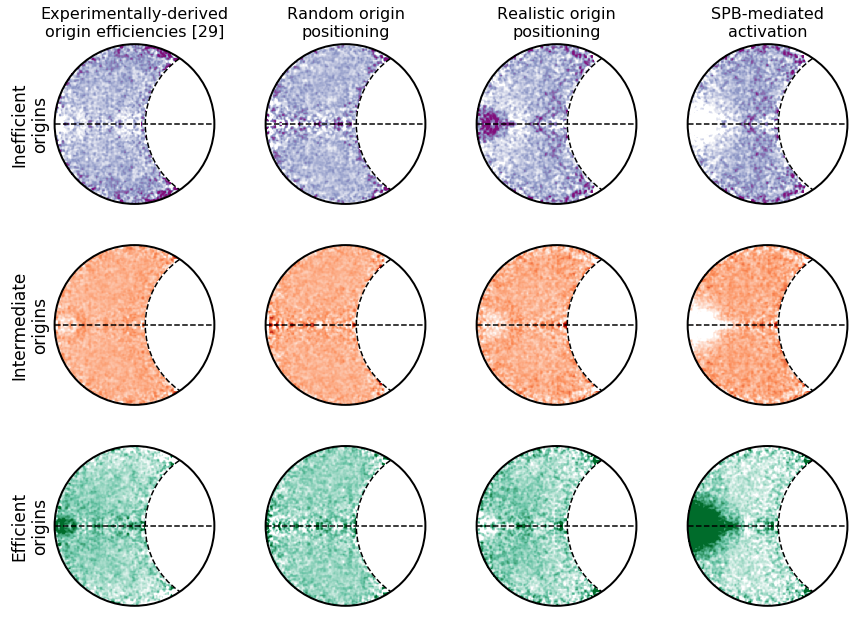

In [28]:
plotFile = savedir + r'/average-efficiency-kde.pdf'
vmin = 0.5
vmax = 2.0

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(4*3, 3*3))
colTitles = ['Experimentally-derived\norigin efficiencies [29]', 'Random origin\npositioning', 'Realistic origin\npositioning', 'SPB-mediated\nactivation']
for ax, colTitle in zip(axes[0, :], colTitles):
    ax.annotate(colTitle, xy=(0.5, 1), xytext=(0, 5), xycoords='axes fraction', textcoords='offset points', size=16, ha='center', va='baseline')
rowTitles = ['Inefficient\norigins', 'Intermediate\norigins', 'Efficient\norigins']
for ax, rowTitle in zip(axes[:, 0], rowTitles):
    ax.annotate(rowTitle, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 7, 0), xycoords=ax.yaxis.label, textcoords='offset points', size=17, ha='center', va='center', rotation=90)
    
def plotRow(axrow, key, cmap):
    expRelRadialKDE = effResults[key]['expRadialKDE'] / (effResults['ALL']['expRadialKDE'] + np.finfo(np.float64).eps)
    ranRelRadialKDE = effResults[key]['ranRadialKDE'] / (effResults['ALL']['ranRadialKDE'] + np.finfo(np.float64).eps)
    uniRelRadialKDE = effResults[key]['uniRadialKDE'] / (effResults['ALL']['uniRadialKDE'] + np.finfo(np.float64).eps)
    spbRelRadialKDE = effResults[key]['spbRadialKDE'] / (effResults['ALL']['spbRadialKDE'] + np.finfo(np.float64).eps)
    plotRadialKDE(axrow[0], expRelRadialKDE, vmin, vmax, cmap)
    plotRadialKDE(axrow[1], ranRelRadialKDE, vmin, vmax, cmap)
    plotRadialKDE(axrow[2], uniRelRadialKDE, vmin, vmax, cmap)
    plotRadialKDE(axrow[3], spbRelRadialKDE, vmin, vmax, cmap)
    
plotRow(axes[0, :], 'LOW', cmap_purple)
plotRow(axes[1, :], 'MEDIUM', cmap_orange)
plotRow(axes[2, :], 'HIGH', cmap_green)

plt.tight_layout()
plt.savefig(plotFile, bbox_inches='tight')
plt.show()

## Individual activation times
<a id="indact"></a>
(Supplement)

[Return to top](#top)

In [29]:
from threading import Thread
import matplotlib.image as mpimg

bw = 0.015
delta = 0.01

ranData = loadSimulatedKDEData(basedir + r'/Data/G1_constraint_100',
                               basedir + r'/Data/orieff_heichinger.csv',
                               basedir + r'/Data/oripos_heichinger.csv',
                               basedir + r'/Simulations/runA_ran/out', r'.*_firingTimes\.csv')

uniData = loadSimulatedKDEData(basedir + r'/Data/G1_grand_eve',
                               basedir + r'/Data/orieff_heichinger.csv',
                               basedir + r'/Data/oripos_heichinger.csv',
                               basedir + r'/Simulations/runA_uni/out', r'.*_firingTimes\.csv')

spbData = loadSimulatedKDEData(basedir + r'/Data/G1_grand_eve',
                               basedir + r'/Data/orieff_heichinger.csv',
                               basedir + r'/Data/oripos_heichinger.csv',
                               basedir + r'/Simulations/runA_spb/out', r'.*_firingTimes\.csv')

tactResults = {}
plotX = np.arange(-1.33 + delta/2, 1.33 + delta/2, delta)
plotR = np.arange(0 + delta/2, 1.33 + delta/2, delta)

ranDataX, ranDataR = rotationallyNormalize(ranData.POSX, ranData.POSY, ranData.POSZ)
uniDataX, uniDataR = rotationallyNormalize(uniData.POSX, uniData.POSY, uniData.POSZ)
spbDataX, spbDataR = rotationallyNormalize(spbData.POSX, spbData.POSY, spbData.POSZ)

def runAll():
    ranRadialKDE = np.array([[computeRadialKDE(x, r, ranDataX, ranDataR, bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    uniRadialKDE = np.array([[computeRadialKDE(x, r, uniDataX, uniDataR, bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    spbRadialKDE = np.array([[computeRadialKDE(x, r, spbDataX, spbDataR, bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    tactResults['ALL'] = {'ranRadialKDE': ranRadialKDE, 'uniRadialKDE': uniRadialKDE, 'spbRadialKDE': spbRadialKDE}

def runLow():
    ranMask = np.array(ranData.TACT_SIM < ranData.TACT_SIM.quantile(0.25), dtype=bool)
    uniMask = np.array(uniData.TACT_SIM < uniData.TACT_SIM.quantile(0.25), dtype=bool)
    spbMask = np.array(spbData.TACT_SIM < spbData.TACT_SIM.quantile(0.25), dtype=bool)
    ranRadialKDE = np.array([[computeRadialKDE(x, r, ranDataX[ranMask], ranDataR[ranMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    uniRadialKDE = np.array([[computeRadialKDE(x, r, uniDataX[uniMask], uniDataR[uniMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    spbRadialKDE = np.array([[computeRadialKDE(x, r, spbDataX[spbMask], spbDataR[spbMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    tactResults['LOW'] = {'ranRadialKDE': ranRadialKDE, 'uniRadialKDE': uniRadialKDE, 'spbRadialKDE': spbRadialKDE}

def runMedium():
    ranMask = np.array((ranData.TACT_SIM >= ranData.TACT_SIM.quantile(0.25)) & (ranData.TACT_SIM <= ranData.TACT_SIM.quantile(0.75)), dtype=bool)
    uniMask = np.array((uniData.TACT_SIM >= uniData.TACT_SIM.quantile(0.25)) & (uniData.TACT_SIM <= uniData.TACT_SIM.quantile(0.75)), dtype=bool)
    spbMask = np.array((spbData.TACT_SIM >= spbData.TACT_SIM.quantile(0.25)) & (spbData.TACT_SIM <= spbData.TACT_SIM.quantile(0.75)), dtype=bool)
    ranRadialKDE = np.array([[computeRadialKDE(x, r, ranDataX[ranMask], ranDataR[ranMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    uniRadialKDE = np.array([[computeRadialKDE(x, r, uniDataX[uniMask], uniDataR[uniMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    spbRadialKDE = np.array([[computeRadialKDE(x, r, spbDataX[spbMask], spbDataR[spbMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    tactResults['MEDIUM'] = {'ranRadialKDE': ranRadialKDE, 'uniRadialKDE': uniRadialKDE, 'spbRadialKDE': spbRadialKDE}

def runHigh():    
    ranMask = np.array(ranData.TACT_SIM > ranData.TACT_SIM.quantile(0.75), dtype=bool)
    uniMask = np.array(uniData.TACT_SIM > uniData.TACT_SIM.quantile(0.75), dtype=bool)
    spbMask = np.array(spbData.TACT_SIM > spbData.TACT_SIM.quantile(0.75), dtype=bool)
    ranRadialKDE = np.array([[computeRadialKDE(x, r, ranDataX[ranMask], ranDataR[ranMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    uniRadialKDE = np.array([[computeRadialKDE(x, r, uniDataX[uniMask], uniDataR[uniMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    spbRadialKDE = np.array([[computeRadialKDE(x, r, spbDataX[spbMask], spbDataR[spbMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    tactResults['HIGH'] = {'ranRadialKDE': ranRadialKDE, 'uniRadialKDE': uniRadialKDE, 'spbRadialKDE': spbRadialKDE}

threadAll = Thread(target=runAll)
threadLow = Thread(target=runLow)
threadMedium = Thread(target=runMedium)
threadHigh = Thread(target=runHigh)

threadAll.start()
threadLow.start() 
threadMedium.start()
threadHigh.start()

threadAll.join()
threadLow.join()
threadMedium.join()
threadHigh.join()

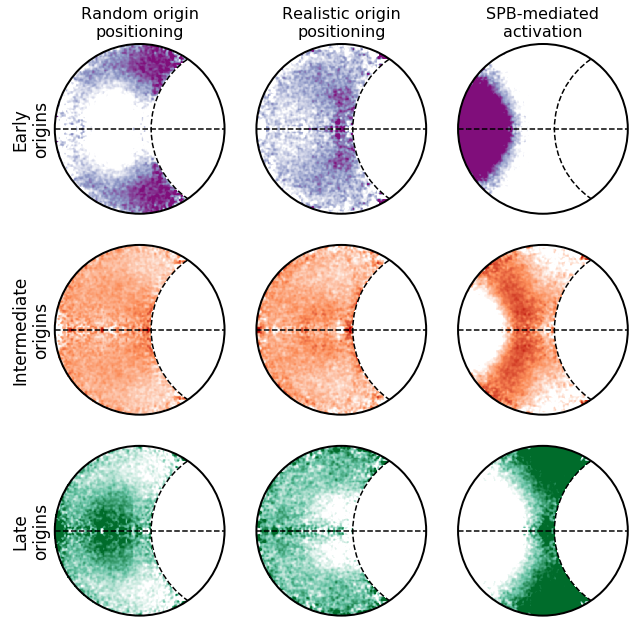

In [30]:
plotFile = savedir + r'/individual-time-kde.pdf'
vmin = 0.5
vmax = 2

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(3*3, 3*3))
colTitles = ['Random origin\npositioning', 'Realistic origin\npositioning', 'SPB-mediated\nactivation']
for ax, colTitle in zip(axes[0, :], colTitles):
    ax.annotate(colTitle, xy=(0.5, 1), xytext=(0, 5), xycoords='axes fraction', textcoords='offset points', size=16, ha='center', va='baseline')
rowTitles = ['Early\norigins', 'Intermediate\norigins', 'Late\norigins']
for ax, rowTitle in zip(axes[:, 0], rowTitles):
    ax.annotate(rowTitle, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 7, 0), xycoords=ax.yaxis.label, textcoords='offset points', size=17, ha='center', va='center', rotation=90)
    
def plotRow(axrow, key, cmap):
    ranRelRadialKDE = tactResults[key]['ranRadialKDE'] / (tactResults['ALL']['ranRadialKDE'] + np.finfo(np.float64).eps)
    uniRelRadialKDE = tactResults[key]['uniRadialKDE'] / (tactResults['ALL']['uniRadialKDE'] + np.finfo(np.float64).eps)
    spbRelRadialKDE = tactResults[key]['spbRadialKDE'] / (tactResults['ALL']['spbRadialKDE'] + np.finfo(np.float64).eps)
    plotRadialKDE(axrow[0], ranRelRadialKDE, vmin, vmax, cmap)
    plotRadialKDE(axrow[1], uniRelRadialKDE, vmin, vmax, cmap)
    plotRadialKDE(axrow[2], spbRelRadialKDE, vmin, vmax, cmap)

plotRow(axes[0, :], 'LOW', cmap_purple)
plotRow(axes[1, :], 'MEDIUM', cmap_orange)
plotRow(axes[2, :], 'HIGH', cmap_green)

plt.tight_layout()
plt.savefig(plotFile, bbox_inches='tight')
plt.show()

## Average activation time
<a id="avgact"></a>
(Figure 3)

[Return to top](#top)

In [31]:
from threading import Thread
import matplotlib.image as mpimg

bw = 0.015
delta = 0.01

expData = loadExperimentalKDEData(basedir + r'/Data/G1_grand_eve',
                                  basedir + r'/Data/orieff_heichinger.csv',
                                  basedir + r'/Data/oripos_heichinger.csv',
                                  basedir + r'/Data/oritact_lygeros.csv')

ranData = loadAverageSimulatedKDEData(basedir + r'/Data/G1_constraint_100',
                                      basedir + r'/Data/orieff_heichinger.csv',
                                      basedir + r'/Data/oripos_heichinger.csv',
                                      basedir + r'/Simulations/runA_ran/out', r'.*_firingTimes\.csv')

uniData = loadAverageSimulatedKDEData(basedir + r'/Data/G1_grand_eve',
                                      basedir + r'/Data/orieff_heichinger.csv',
                                      basedir + r'/Data/oripos_heichinger.csv',
                                      basedir + r'/Simulations/runA_uni/out', r'.*_firingTimes\.csv')

spbData = loadAverageSimulatedKDEData(basedir + r'/Data/G1_grand_eve',
                                      basedir + r'/Data/orieff_heichinger.csv',
                                      basedir + r'/Data/oripos_heichinger.csv',
                                      basedir + r'/Simulations/runA_spb/out', r'.*_firingTimes\.csv')

tactResults = {}
plotX = np.arange(-1.33 + delta/2, 1.33 + delta/2, delta)
plotR = np.arange(0 + delta/2, 1.33 + delta/2, delta)

expDataX, expDataR = rotationallyNormalize(expData.POSX, expData.POSY, expData.POSZ)
ranDataX, ranDataR = rotationallyNormalize(ranData.POSX, ranData.POSY, ranData.POSZ)
uniDataX, uniDataR = rotationallyNormalize(uniData.POSX, uniData.POSY, uniData.POSZ)
spbDataX, spbDataR = rotationallyNormalize(spbData.POSX, spbData.POSY, spbData.POSZ)

def runAll():
    expRadialKDE = np.array([[computeRadialKDE(x, r, expDataX, expDataR, bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    ranRadialKDE = np.array([[computeRadialKDE(x, r, ranDataX, ranDataR, bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    uniRadialKDE = np.array([[computeRadialKDE(x, r, uniDataX, uniDataR, bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    spbRadialKDE = np.array([[computeRadialKDE(x, r, spbDataX, spbDataR, bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    tactResults['ALL'] = {'expRadialKDE': expRadialKDE, 'ranRadialKDE': ranRadialKDE, 'uniRadialKDE': uniRadialKDE, 'spbRadialKDE': spbRadialKDE}

def runLow():
    expMask = np.array(expData.TACT < expData.TACT.quantile(0.25), dtype=bool)
    ranMask = np.array(ranData.TACT_SIM < ranData.TACT_SIM.quantile(0.25), dtype=bool)
    uniMask = np.array(uniData.TACT_SIM < uniData.TACT_SIM.quantile(0.25), dtype=bool)
    spbMask = np.array(spbData.TACT_SIM < spbData.TACT_SIM.quantile(0.25), dtype=bool)
    expRadialKDE = np.array([[computeRadialKDE(x, r, expDataX[expMask], expDataR[expMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    ranRadialKDE = np.array([[computeRadialKDE(x, r, ranDataX[ranMask], ranDataR[ranMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    uniRadialKDE = np.array([[computeRadialKDE(x, r, uniDataX[uniMask], uniDataR[uniMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    spbRadialKDE = np.array([[computeRadialKDE(x, r, spbDataX[spbMask], spbDataR[spbMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    tactResults['LOW'] = {'expRadialKDE': expRadialKDE, 'ranRadialKDE': ranRadialKDE, 'uniRadialKDE': uniRadialKDE, 'spbRadialKDE': spbRadialKDE}

def runMedium():
    expMask = np.array((expData.TACT >= expData.TACT.quantile(0.25)) & (expData.TACT <= expData.TACT.quantile(0.75)), dtype=bool)
    ranMask = np.array((ranData.TACT_SIM >= ranData.TACT_SIM.quantile(0.25)) & (ranData.TACT_SIM <= ranData.TACT_SIM.quantile(0.75)), dtype=bool)
    uniMask = np.array((uniData.TACT_SIM >= uniData.TACT_SIM.quantile(0.25)) & (uniData.TACT_SIM <= uniData.TACT_SIM.quantile(0.75)), dtype=bool)
    spbMask = np.array((spbData.TACT_SIM >= spbData.TACT_SIM.quantile(0.25)) & (spbData.TACT_SIM <= spbData.TACT_SIM.quantile(0.75)), dtype=bool)
    expRadialKDE = np.array([[computeRadialKDE(x, r, expDataX[expMask], expDataR[expMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    ranRadialKDE = np.array([[computeRadialKDE(x, r, ranDataX[ranMask], ranDataR[ranMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    uniRadialKDE = np.array([[computeRadialKDE(x, r, uniDataX[uniMask], uniDataR[uniMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    spbRadialKDE = np.array([[computeRadialKDE(x, r, spbDataX[spbMask], spbDataR[spbMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    tactResults['MEDIUM'] = {'expRadialKDE': expRadialKDE, 'ranRadialKDE': ranRadialKDE, 'uniRadialKDE': uniRadialKDE, 'spbRadialKDE': spbRadialKDE}

def runHigh():    
    expMask = np.array(expData.TACT > expData.TACT.quantile(0.75), dtype=bool)
    ranMask = np.array(ranData.TACT_SIM > ranData.TACT_SIM.quantile(0.75), dtype=bool)
    uniMask = np.array(uniData.TACT_SIM > uniData.TACT_SIM.quantile(0.75), dtype=bool)
    spbMask = np.array(spbData.TACT_SIM > spbData.TACT_SIM.quantile(0.75), dtype=bool)
    expRadialKDE = np.array([[computeRadialKDE(x, r, expDataX[expMask], expDataR[expMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    ranRadialKDE = np.array([[computeRadialKDE(x, r, ranDataX[ranMask], ranDataR[ranMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    uniRadialKDE = np.array([[computeRadialKDE(x, r, uniDataX[uniMask], uniDataR[uniMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    spbRadialKDE = np.array([[computeRadialKDE(x, r, spbDataX[spbMask], spbDataR[spbMask], bw) if inDomain(x, r) else 0 for x in plotX] for r in plotR])
    tactResults['HIGH'] = {'expRadialKDE': expRadialKDE, 'ranRadialKDE': ranRadialKDE, 'uniRadialKDE': uniRadialKDE, 'spbRadialKDE': spbRadialKDE}

threadAll = Thread(target=runAll)
threadLow = Thread(target=runLow)
threadMedium = Thread(target=runMedium)
threadHigh = Thread(target=runHigh)

threadAll.start()
threadLow.start() 
threadMedium.start()
threadHigh.start()

threadAll.join()
threadLow.join()
threadMedium.join()
threadHigh.join()

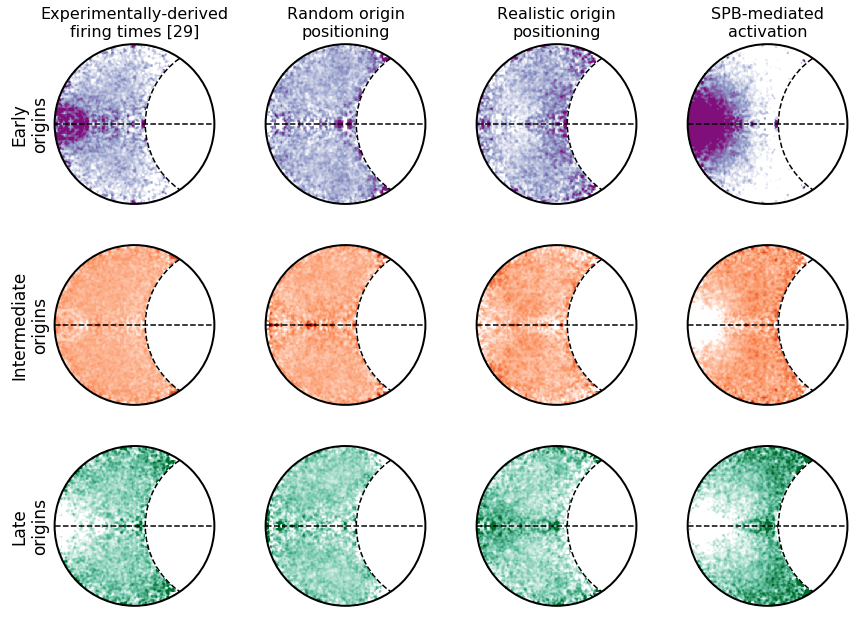

In [32]:
plotFile = savedir + r'/average-time-kde.pdf'
vmin = 0.5
vmax = 2

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(4*3, 3*3))
colTitles = ['Experimentally-derived\nfiring times [29]', 'Random origin\npositioning', 'Realistic origin\npositioning', 'SPB-mediated\nactivation']
for ax, colTitle in zip(axes[0, :], colTitles):
    ax.annotate(colTitle, xy=(0.5, 1), xytext=(0, 5), xycoords='axes fraction', textcoords='offset points', size=16, ha='center', va='baseline')
rowTitles = ['Early\norigins', 'Intermediate\norigins', 'Late\norigins']
for ax, rowTitle in zip(axes[:, 0], rowTitles):
    ax.annotate(rowTitle, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 7, 0), xycoords=ax.yaxis.label, textcoords='offset points', size=17, ha='center', va='center', rotation=90)
    
def plotRow(axrow, key, cmap):
    expRelRadialKDE = tactResults[key]['expRadialKDE'] / (tactResults['ALL']['expRadialKDE'] + np.finfo(np.float64).eps)
    ranRelRadialKDE = tactResults[key]['ranRadialKDE'] / (tactResults['ALL']['ranRadialKDE'] + np.finfo(np.float64).eps)
    uniRelRadialKDE = tactResults[key]['uniRadialKDE'] / (tactResults['ALL']['uniRadialKDE'] + np.finfo(np.float64).eps)
    spbRelRadialKDE = tactResults[key]['spbRadialKDE'] / (tactResults['ALL']['spbRadialKDE'] + np.finfo(np.float64).eps)
    plotRadialKDE(axrow[0], expRelRadialKDE, vmin, vmax, cmap)
    plotRadialKDE(axrow[1], ranRelRadialKDE, vmin, vmax, cmap)
    plotRadialKDE(axrow[2], uniRelRadialKDE, vmin, vmax, cmap)
    plotRadialKDE(axrow[3], spbRelRadialKDE, vmin, vmax, cmap)
    
plotRow(axes[0, :], 'LOW', cmap_purple)
plotRow(axes[1, :], 'MEDIUM', cmap_orange)
plotRow(axes[2, :], 'HIGH', cmap_green)

plt.tight_layout()
plt.savefig(plotFile, bbox_inches='tight')
plt.show()

## Sensitivity analysis
<a id='sens'></a>
Figure 4

[Return to top](#top)

/Users/amelia/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


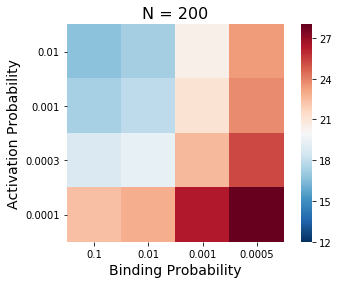

/Users/amelia/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


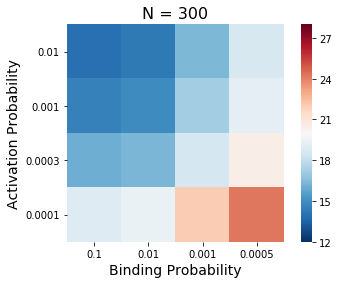

/Users/amelia/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


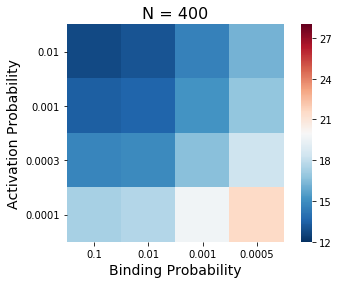

/Users/amelia/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


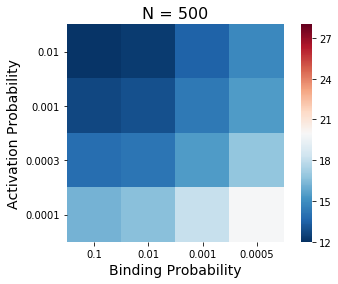

In [33]:
nRange = [200, 300, 400, 500]
bRange = [0.1, 0.01, 0.001, 0.0005]
aRange = [0.01, 0.001, 0.0003, 0.0001]

for n in nRange:
    completionMatrix = pd.DataFrame(np.zeros((len(bRange),len(aRange))), columns=bRange, index=aRange)
    for b in bRange:
        for a in aRange:
            inputFile = basedir + '/Simulations/runB/out/SIM_N' + str(n) + '_D0.5_R0.025_P' + str(b) + '_A' + str(a) + '_completionTimes.csv'
            simdata = np.genfromtxt(inputFile, delimiter=',')
            tcompls = simdata[1:, 2]
            tcompls = tcompls[np.nonzero(tcompls)]
            completionMatrix[b][a] = np.mean(tcompls) / 60
    sns.heatmap(completionMatrix, square=True, cmap="RdBu_r", vmin=12, vmax=28, annot=False)
    ax = plt.axes()
    ax.set_title("N = " + str(n), size=16)
    ax.set_xlabel("Binding Probability", size=14)
    ax.set_ylabel("Activation Probability", size=14)
    plt.yticks(rotation=0)
    plt.savefig(savedir + r'/sensitivity_heatmap_' + str(n) + '.pdf')
    plt.show()

## Replication kinetics
<a id='kinetics'></a>
Figure 7

[Return to top](#top)

In [34]:
import scipy.interpolate as interpolate
import scipy.integrate as integrate
from cycler import cycler

def loadBatchSimulationInput(toriFile, line):
    firingEvents = []
    firingTimes = linecache.getline(toriFile, line).split(',')[2:]
    originNames = linecache.getline(toriFile, 1).split(',')[2:]
    for i in range(len(firingTimes)):
        if float(firingTimes[i]) != 0:
            firingEvents.append({
                'TIME': float(firingTimes[i]),
                'ORI': oriIndexToName(i)
            })
    return firingEvents
            
def loadOriginLocationData(oriPosFile):
    # Positions of contigs, index+1 is the chromosome number
    contigStarts = [[90482], [95333, 1649714], [33022, 1144015]]
    contigEnds = [[5536805], [1592104, 4426877], [1065321, 2431946]]
    contigStartFlag = True
    origins = {}
    oriPos = pd.read_csv(oriPosFile, names=['ORI', 'CHR', 'POS'])
    for index, row in oriPos.iterrows():
        info = {
            'CHR': int(row.CHR),
            'POS': int(row.POS)
        }
        # Test if start/end of contig. Extra 50 bp beyond ends of contigs will be simulated
        if contigStartFlag:
            for startPos in contigStarts[info['CHR'] - 1]:
                if info['POS'] > startPos:
                    info['NBRL'] = ['TERM', startPos - 50]
            contigStartFlag = False
        else:
            for endPos in contigEnds[info['CHR'] - 1]:
                if (index == len(oriPos) - 1) or (info['POS'] < endPos) and ((oriPos.at[index + 1, 'CHR'] != info['CHR']) or (oriPos.at[index + 1, 'POS'] > endPos)):
                    info['NBRR'] = ['TERM', endPos + 50]
                    contigStartFlag = True
        # Fill in neighbors if they're not the end of a contig
        if not ('NBRL' in info):
            info['NBRL'] = [oriPos.at[index - 1, 'ORI'], int(oriPos.at[index - 1, 'POS'])]
        if not ('NBRR' in info):
            info['NBRR'] = [oriPos.at[index + 1, 'ORI'], int(oriPos.at[index + 1, 'POS'])] 
        origins[row['ORI']] = info
    return origins

def isSameContig(oriA, oriB):
    if oriA['CHR'] != oriB['CHR']:
        return False
    contigStarts = [[90482], [95333, 1649714], [33022, 1144015]][oriA['CHR'] - 1]
    for startPos in contigStarts:
        # start of a new contig is between the origins
        if (oriA['POS'] < startPos <= oriB['POS']) or (oriB['POS'] < startPos <= oriA['POS']):
            return False
    return True
    
def getTermCollisionTime(termPos, oriPos, firingTime):
    return firingTime + abs((oriPos - termPos) / vFork)

def getOriCollisionTime(eventA, eventB, originLocationData):
    distance = abs(originLocationData[eventA.ORI]['POS'] - originLocationData[eventB.ORI]['POS'])
    return (eventA.TIME + eventB.TIME) / 2 + distance / (2 * vFork)

def getReplicationEvents(firingEv, originLocationData):
    collisionEvents = {
        'TIME': [],
        'DFORK': []
    }
    firingEvents = pd.DataFrame(firingEv).sort_values('ORI').reset_index(drop=True)
    firingEvents['DFORK'] = 2
    for index, event in firingEvents.iterrows():
        # this origin and the next neighbor firing one are not in the same contig
        if (index == len(firingEvents) - 1) or (not isSameContig(originLocationData[event.ORI], originLocationData[firingEvents.at[index + 1, 'ORI']])): 
            collisionEvents['TIME'].append(getTermCollisionTime(originLocationData[event.ORI]['NBRR'][1], originLocationData[event.ORI]['POS'], event.TIME))
            collisionEvents['DFORK'].append(-1)
        else:
            # this origin and the prev neighbor firing one are not in the same contig
            if (index == 0) or not isSameContig(originLocationData[event.ORI], originLocationData[firingEvents.at[index - 1, 'ORI']]): 
                collisionEvents['TIME'].append(getTermCollisionTime(originLocationData[event.ORI]['NBRL'][1], originLocationData[event.ORI]['POS'], event.TIME))
                collisionEvents['DFORK'].append(-1)
            # get collision with the next neighbor firing ori
            collisionEvents['TIME'].append(getOriCollisionTime(event, firingEvents.iloc[index + 1], originLocationData))
            collisionEvents['DFORK'].append(-2)
    del firingEvents['ORI']
    collisionEvents = pd.DataFrame(collisionEvents)
    return pd.concat([firingEvents, collisionEvents]).sort_values('TIME').reset_index(drop=True)

def trackOriginStates(firingEv, originLocationData):
    originTracker = [] # contains [TIME, PRE, REPL2, REPL1, POST, PASS]
    originTracker.append([0, 893, 0, 0, 0, 0])
    # Passively replicated origins
    firingEvents = pd.DataFrame(firingEv).sort_values('ORI').reset_index(drop=True)
    passiveOris = []
    activeOris = firingEvents['ORI'].tolist()
    for i in range(893):
        if not oriIndexToName(i) in activeOris:
            passiveOris.append(oriIndexToName(i))
    for passOri in passiveOris:
        tPass = 0
        for i, ev in firingEvents.iterrows():
            if isSameContig(originLocationData[ev.ORI], originLocationData[passOri]):
                # tPass = tFired + distance / 50
                if not tPass:
                    tPass = ev.TIME + abs(originLocationData[ev.ORI]['POS'] - originLocationData[passOri]['POS']) / 50
                else:
                    tPass = min(tPass, ev.TIME + abs(originLocationData[ev.ORI]['POS'] - originLocationData[passOri]['POS']) / 50)
        originTracker.append([tPass, -1, 0, 0, 0, 1])
    # Actively replicated origins
    activeOriTimes = [[] for i in range(893)]
    for index, event in firingEvents.iterrows():
        activeOriTimes[oriNameToIndex(event.ORI)].append(event.TIME)
        # this origin and the next neighbor firing one are not in the same contig
        if (index == len(firingEvents) - 1) or (not isSameContig(originLocationData[event.ORI], originLocationData[firingEvents.at[index + 1, 'ORI']])): 
            activeOriTimes[oriNameToIndex(event.ORI)].append(getTermCollisionTime(originLocationData[event.ORI]['NBRR'][1], originLocationData[event.ORI]['POS'], event.TIME))
        else:
            activeOriTimes[oriNameToIndex(event.ORI)].append(getOriCollisionTime(event, firingEvents.iloc[index + 1], originLocationData))
        # this origin and the prev neighbor firing one are not in the same contig
        if (index == 0) or not isSameContig(originLocationData[event.ORI], originLocationData[firingEvents.at[index - 1, 'ORI']]): 
            activeOriTimes[oriNameToIndex(event.ORI)].append(getTermCollisionTime(originLocationData[event.ORI]['NBRL'][1], originLocationData[event.ORI]['POS'], event.TIME))
        else:
            activeOriTimes[oriNameToIndex(event.ORI)].append(getOriCollisionTime(event, firingEvents.iloc[index - 1], originLocationData))
    # Replication event times for active origins
    for oriTime in activeOriTimes:
        if len(oriTime) > 0:
            oriTime.sort()
            originTracker.append([oriTime[0], -1, 1, 0, 0, 0]) # Pre -> ReplLR
            originTracker.append([oriTime[1], 0, -1, 1, 0, 0]) # ReplLR -> ReplL/R
            originTracker.append([oriTime[2], 0, 0, -1, 1, 0]) # ReplL/R -> Post
    originTracker = pd.DataFrame(originTracker, columns=['TIME', 'PRE', 'REPL2', 'REPL1', 'POST', 'PASS']).sort_values('TIME').reset_index(drop=True)
    originStates = originTracker.cumsum(axis=0)
    del originStates['TIME']
    originStates['TIME'] = originTracker['TIME']
    return originStates

def length(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

def getMeanOriStateXY(oriPosFile, inputFile, lineRange, timeSpan):
    oriLocs = loadOriginLocationData(oriPosFile)
    interpolations = [[], [], [], [], []] # PRE, REPL2, REPL1, POST, PASS
    for line in range(lineRange[0], lineRange[-1]):
        firingEvents = loadBatchSimulationInput(inputFile, line)
        replicationEvents = trackOriginStates(firingEvents, oriLocs)
        interpolations[0].append(interpolate.interp1d(np.array(replicationEvents.TIME / 60), np.array(replicationEvents.PRE), bounds_error=False, fill_value=(replicationEvents.PRE.tolist()[0], replicationEvents.PRE.tolist()[-1])))
        interpolations[1].append(interpolate.interp1d(np.array(replicationEvents.TIME / 60), np.array(replicationEvents.REPL2), bounds_error=False, fill_value=(replicationEvents.REPL2.tolist()[0], replicationEvents.REPL2.tolist()[-1])))
        interpolations[2].append(interpolate.interp1d(np.array(replicationEvents.TIME / 60), np.array(replicationEvents.REPL1), bounds_error=False, fill_value=(replicationEvents.REPL1.tolist()[0], replicationEvents.REPL1.tolist()[-1])))
        interpolations[3].append(interpolate.interp1d(np.array(replicationEvents.TIME / 60), np.array(replicationEvents.POST), bounds_error=False, fill_value=(replicationEvents.POST.tolist()[0], replicationEvents.POST.tolist()[-1])))
        interpolations[4].append(interpolate.interp1d(np.array(replicationEvents.TIME / 60), np.array(replicationEvents.PASS), bounds_error=False, fill_value=(replicationEvents.PASS.tolist()[0], replicationEvents.PASS.tolist()[-1])))
    xvals = np.arange(0, timeSpan, 0.01)
    yvals = [[], [], [], [], []]
    for x in xvals:
        for i in range(5):
            total = 0
            for f in interpolations[i]:
                total += f(x)
            yvals[i].append(total / len(interpolations[i]))
    return xvals, yvals

### Origin states
<a id='oristates'></a>
[Return to top](#top)

In [35]:
oriPosFile = basedir + r'/Data/oripos_heichinger.csv'
inputFile = basedir + r'/Simulations/runB/out/SIM_N300_D0.5_R0.025_P0.001_A0.0001_firingTimes.csv'
xvals, yvals = getMeanOriStateXY(oriPosFile, inputFile, (3, 100), 22)

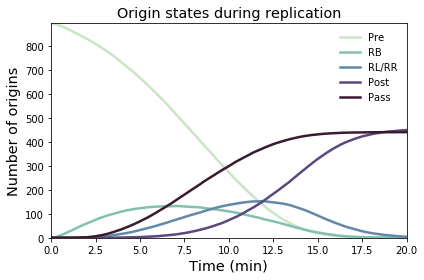

In [36]:
plotFile = savedir + r'/origin-states.pdf'
ax = plt.figure(figsize=(6,4)).gca()
ax.set_prop_cycle(cycler(color=sns.cubehelix_palette(5, start=-2.1, rot=-.8)))
ax.set_xlabel('Time (min)', size='x-large')
ax.set_ylabel('Number of origins', size='x-large')
ax.set_title('Origin states during replication', size='x-large')
ax.set_xlim(0, 20)
ax.set_ylim(0, 893)
ax.plot(xvals, yvals[0], linewidth=2.5, label="Pre")
ax.plot(xvals, yvals[1], linewidth=2.5, label="RB")
ax.plot(xvals, yvals[2], linewidth=2.5, label="RL/RR")
ax.plot(xvals, yvals[3], linewidth=2.5, label="Post")
ax.plot(xvals, yvals[4], linewidth=2.5, label="Pass")
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig(plotFile, bbox_inches='tight')
plt.show()

### Bound factors
<a id='bound'></a>
[Return to top](#top)

In [37]:
def getMeanBoundXY(oriPosFile, inputFile, lineRange, timeSpan):
    oriLocs = loadOriginLocationData(oriPosFile)
    interpolations = []
    for line in range(lineRange[0], lineRange[-1]):
        firingEvents = loadBatchSimulationInput(inputFile, line)
        replicationEvents = getReplicationEvents(firingEvents, oriLocs)
        boundFactors = []
        bound = 0
        for dfork in replicationEvents.DFORK:
            bound += dfork / 2.0
            boundFactors.append(bound)
        replicationEvents['BOUND'] = boundFactors
        interpolations.append(interpolate.interp1d(np.array(replicationEvents.TIME / 60), np.array(replicationEvents.BOUND), bounds_error=False, fill_value=0))
    xvals = np.arange(0, timeSpan, 0.01)
    yvals = []
    for x in xvals:
        total = 0
        for f in interpolations:
            total += f(x)
        yvals.append(total / len(interpolations))
    return xvals, yvals

oriPosFile = basedir + r'/Data/oripos_heichinger.csv'
inputFile = basedir + r'/Simulations/runB/out/SIM_N300_D0.5_R0.025_P0.001_A0.0001_firingTimes.csv'

x, ybound = getMeanBoundXY(oriPosFile, inputFile, (3, length(inputFile)), 20)
yfree = [300 - y for y in ybound]

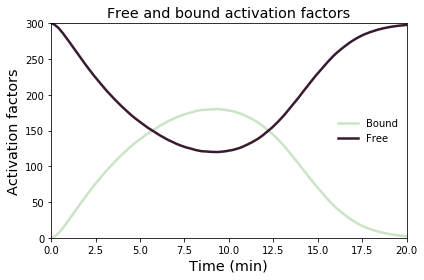

In [38]:
plotFile = savedir + r'/bound-factors.pdf'
ax = plt.figure(figsize=(6,4)).gca()
ax.set_prop_cycle(cycler(color=sns.cubehelix_palette(2, start=-2.1, rot=-.8)))
ax.set_xlabel('Time (min)', size='x-large')
ax.set_ylabel('Activation factors', size='x-large')
ax.set_title('Free and bound activation factors', size='x-large')
ax.set_xlim(0, 20)
ax.set_ylim(0, 300)
ax.plot(x, ybound, linewidth=2.5, label='Bound')
ax.plot(x, yfree, linewidth=2.5, label='Free')
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig(plotFile, bbox_inches='tight')
plt.show()

### Replication rate
<a id='rate'></a>
[Return to top](#top)

In [39]:
def getMeanReplRateXY(oriPosFile, toriFile, timespan):
    oriLocs = loadOriginLocationData(oriPosFile)
    interpolations = []
    for line in range(2, length(toriFile)):
        firingEvents = loadBatchSimulationInput(toriFile, line)
        replicationEvents = getReplicationEvents(firingEvents, oriLocs)
        replicationRates = []
        rate = 0
        for dfork in replicationEvents.DFORK:
            rate += dfork * vFork
            replicationRates.append(rate)
        replicationEvents['RATE'] = replicationRates
        interpolations.append(interpolate.interp1d(np.array(replicationEvents.TIME / 60), np.array(replicationEvents.RATE * 60 / 1000), bounds_error=False, fill_value=0))
    xvals = np.arange(0, timespan, 0.01)
    yvals = []
    for x in xvals:
        total = 0
        for f in interpolations:
            total += f(x)
        yvals.append(total / len(interpolations))
    return xvals, yvals

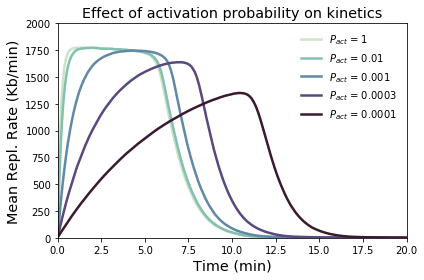

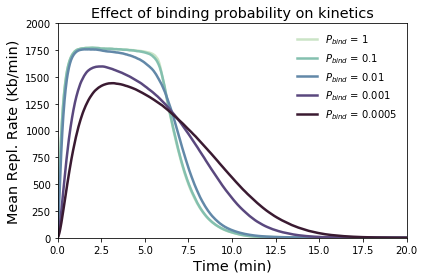

In [40]:
oriPosFile = basedir + r'/Data/oripos_heichinger.csv'
                          
# ACTIVATION PROBABILITY COMPARISON
plotFile = savedir + r'/activation-prob-kinetics.pdf'
ax = plt.figure(figsize=(6,4)).gca()
ax.set_prop_cycle(cycler(color=sns.cubehelix_palette(5, start=-2.1, rot=-.8)))
ax.set_xlabel('Time (min)', size='x-large')
ax.set_ylabel('Mean Repl. Rate (Kb/min)', size='x-large')
ax.set_title('Effect of activation probability on kinetics', size='x-large')
ax.set_xlim(0, 20)
ax.set_ylim(0, 2000)
xvals, yvals = getMeanReplRateXY(oriPosFile, basedir + r'/Simulations/runB/out/SIM_N300_D0.5_R0.025_P0.1_A1_firingTimes.csv', 25)
plt.plot(xvals, yvals, linewidth=2.5, label="$P_{{act}}$ = 1")
xvals, yvals = getMeanReplRateXY(oriPosFile, basedir + r'/Simulations/runB/out/SIM_N300_D0.5_R0.025_P0.1_A0.01_firingTimes.csv', 25)
plt.plot(xvals, yvals, linewidth=2.5, label="$P_{{act}}$ = 0.01")
xvals, yvals = getMeanReplRateXY(oriPosFile, basedir + r'/Simulations/runB/out/SIM_N300_D0.5_R0.025_P0.1_A0.001_firingTimes.csv', 25)
plt.plot(xvals, yvals, linewidth=2.5, label="$P_{{act}}$ = 0.001")
xvals, yvals = getMeanReplRateXY(oriPosFile, basedir + r'/Simulations/runB/out/SIM_N300_D0.5_R0.025_P0.1_A0.0003_firingTimes.csv', 25)
plt.plot(xvals, yvals, linewidth=2.5, label="$P_{{act}}$ = 0.0003")
xvals, yvals = getMeanReplRateXY(oriPosFile, basedir + r'/Simulations/runB/out/SIM_N300_D0.5_R0.025_P0.1_A0.0001_firingTimes.csv', 25)
plt.plot(xvals, yvals, linewidth=2.5, label="$P_{{act}}$ = 0.0001")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(plotFile, bbox_inches='tight')
plt.show()

# BINDING PROBABILITY COMPARISON
plotFile = savedir + r'/binding-prob-kinetics.pdf'
ax = plt.figure(figsize=(6,4)).gca()
ax.set_prop_cycle(cycler(color=sns.cubehelix_palette(5, start=-2.1, rot=-.8)))
ax.set_xlabel('Time (min)', size='x-large')
ax.set_ylabel('Mean Repl. Rate (Kb/min)', size='x-large')
ax.set_title('Effect of binding probability on kinetics', size='x-large')
ax.set_xlim(0, 20)
ax.set_ylim(0, 2000)
xvals, yvals = getMeanReplRateXY(oriPosFile, basedir + r'/Simulations/runB/out/SIM_N300_D0.5_R0.025_P1_A0.01_firingTimes.csv', 25)
plt.plot(xvals, yvals, linewidth=2.5, label="$P_{{bind}}$ = 1")
xvals, yvals = getMeanReplRateXY(oriPosFile, basedir + r'/Simulations/runB/out/SIM_N300_D0.5_R0.025_P0.1_A0.01_firingTimes.csv', 25)
plt.plot(xvals, yvals, linewidth=2.5, label="$P_{{bind}}$ = 0.1")
xvals, yvals = getMeanReplRateXY(oriPosFile, basedir + r'/Simulations/runB/out/SIM_N300_D0.5_R0.025_P0.01_A0.01_firingTimes.csv', 25)
plt.plot(xvals, yvals, linewidth=2.5, label="$P_{{bind}}$ = 0.01")
xvals, yvals = getMeanReplRateXY(oriPosFile, basedir + r'/Simulations/runB/out/SIM_N300_D0.5_R0.025_P0.001_A0.01_firingTimes.csv', 25)
plt.plot(xvals, yvals, linewidth=2.5, label="$P_{{bind}}$ = 0.001")
xvals, yvals = getMeanReplRateXY(oriPosFile, basedir + r'/Simulations/runB/out/SIM_N300_D0.5_R0.025_P0.0005_A0.01_firingTimes.csv', 25)
plt.plot(xvals, yvals, linewidth=2.5, label="$P_{{bind}}$ = 0.0005")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(plotFile, bbox_inches='tight')
plt.show()

## I(t)
<a id='it'></a>
Figure 7

[Return to top](#top)

In [59]:
oriPosFile = basedir + r'/Data/oripos_heichinger.csv'
genomeSize = 12040421 + 100000

def getItArray(oriPosFile, inputFile, timerange=30*60, dt=60):
    oriLocs = loadOriginLocationData(oriPosFile)
    times = np.array(range(timerange))
    it = np.zeros(times.shape)
    endline = length(inputFile)
    #endline=50
    for line in range(2, endline):
        firingEvents = loadBatchSimulationInput(inputFile, line)
        replicationEvents = getReplicationEvents(firingEvents, oriLocs).reset_index(drop=True)
        numForks = 0
        rate = 0
        amountReplicated = 0
        for index, event in replicationEvents.iterrows():
            numForks += event.DFORK
            if index == 0:
                amountReplicated += rate * event.TIME
            else:
                amountReplicated += rate * (event.TIME - replicationEvents.at[index - 1, 'TIME'])
            rate += event.DFORK * vFork
            isingle = np.zeros(times.shape)
            start = max(0, int(event.TIME - dt))
            end = min(int(event.TIME + dt), len(isingle) - 1)
            #isingle[start:end] = 60./(end-start)/((genomeSize - amountReplicated) / 1000)
            # kernel[t-dt, t+dt] = 1(event)/unrep(kb)/dt(min)
            isingle[start:end] = 1/((genomeSize - amountReplicated) / 1000)/(dt/60.)
            it = it + isingle
    return times / 60, it / (endline - 2)

In [60]:
file0 = basedir + r'/Simulations/runB/out/SIM_N300_D0.5_R0.025_P0.001_A0.0001_firingTimes.csv'
file1 = basedir + r'/Simulations/runB/out/SIM_N200_D0.5_R0.025_P0.001_A0.0001_firingTimes.csv'
file2 = basedir + r'/Simulations/runB/out/SIM_N500_D0.5_R0.025_P0.001_A0.0001_firingTimes.csv'
file3 = basedir + r'/Simulations/runB/out/SIM_N300_D0.5_R0.025_P0.01_A0.0001_firingTimes.csv'
file4 = basedir + r'/Simulations/runB/out/SIM_N300_D0.5_R0.025_P0.0005_A0.0001_firingTimes.csv'
file5 = basedir + r'/Simulations/runB/out/SIM_N300_D0.5_R0.025_P0.001_A0.01_firingTimes.csv'
file6 = basedir + r'/Simulations/runB/out/SIM_N300_D0.5_R0.025_P0.001_A0.001_firingTimes.csv'

xvals0, yvals0 = getItArray(oriPosFile, file0)
xvals1, yvals1 = getItArray(oriPosFile, file1)
xvals2, yvals2 = getItArray(oriPosFile, file2)
xvals3, yvals3 = getItArray(oriPosFile, file3)
xvals4, yvals4 = getItArray(oriPosFile, file4)
xvals5, yvals5 = getItArray(oriPosFile, file5)
xvals6, yvals6 = getItArray(oriPosFile, file6)

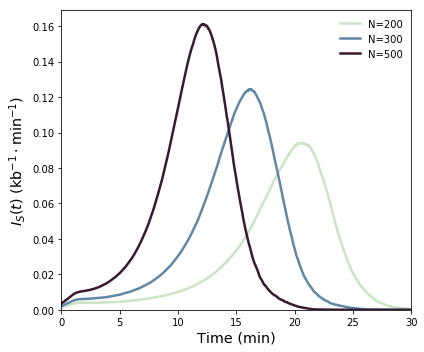

In [61]:
plotFile = savedir + r'/I(t)_N.pdf'
ax = plt.figure(figsize=(6,5)).gca()
ax.set_prop_cycle(cycler(color=sns.cubehelix_palette(3, start=-2.1, rot=-.8)))
ax.set_xlabel('Time (min)', size='x-large')
ax.set_ylabel('$I_S(t)$ (kb$^{-1}\cdot$min$^{-1}$)', size='x-large')
ax.plot(xvals1, yvals1, linewidth=2.5, label='N=200')
ax.plot(xvals0, yvals0, linewidth=2.5, label='N=300')
ax.plot(xvals2, yvals2, linewidth=2.5, label='N=500')
ax.set_xlim(0, 30)
ax.set_ylim(bottom=0)
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(plotFile, bbox_inches='tight')
plt.show()

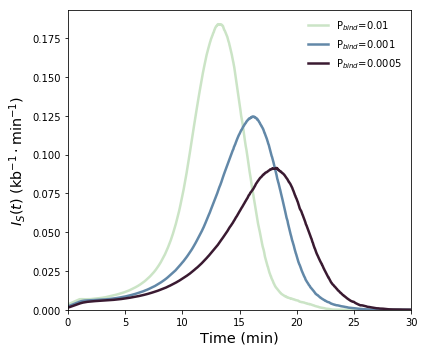

In [62]:
plotFile = savedir + r'/I(t)_P.pdf'
ax = plt.figure(figsize=(6,5)).gca()
ax.set_prop_cycle(cycler(color=sns.cubehelix_palette(3, start=-2.1, rot=-.8)))
ax.set_xlabel('Time (min)', size='x-large')
ax.set_ylabel('$I_S(t)$ (kb$^{-1}\cdot$min$^{-1}$)', size='x-large')
ax.plot(xvals3, yvals3, linewidth=2.5, label='P$_{{bind}}$=0.01')
ax.plot(xvals0, yvals0, linewidth=2.5, label='P$_{{bind}}$=0.001')
ax.plot(xvals4, yvals4, linewidth=2.5, label='P$_{{bind}}$=0.0005')
ax.set_xlim(0, 30)
ax.set_ylim(bottom=0)
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(plotFile, bbox_inches='tight')
plt.show()

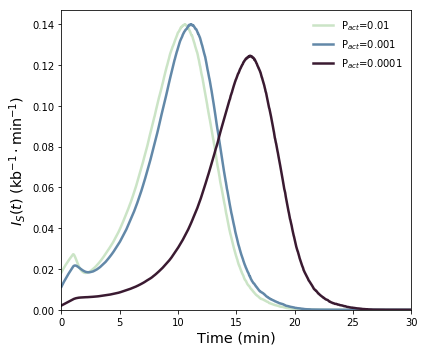

In [63]:
plotFile = savedir + r'/I(t)_A.pdf'
ax = plt.figure(figsize=(6,5)).gca()
ax.set_prop_cycle(cycler(color=sns.cubehelix_palette(3, start=-2.1, rot=-.8)))
ax.set_xlabel('Time (min)', size='x-large')
ax.set_ylabel('$I_S(t)$ (kb$^{-1}\cdot$min$^{-1}$)', size='x-large')
ax.plot(xvals5, yvals5, linewidth=2.5, label='P$_{{act}}$=0.01')
ax.plot(xvals6, yvals6, linewidth=2.5, label='P$_{{act}}$=0.001')
ax.plot(xvals0, yvals0, linewidth=2.5, label='P$_{{act}}$=0.0001')
ax.set_xlim(0, 30)
ax.set_ylim(bottom=0)
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(plotFile, bbox_inches='tight')
plt.show()

## Firing concurrence matrix
<a id='cmatrix'></a>
Figure 5

[Return to top](#top)

### High binding probability
<a id='hibind'></a>

[Return to top](#top)

In [46]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
oriTimesFile = basedir + r'/Simulations/runB/out/SIM_N150_D0.5_R0.025_P0.1_A0.01_firingTimes.csv'
df = pd.read_csv(oriTimesFile)
del df['STRUCTURE']
del df['ITERATION']

In [47]:
firing = np.array(df)
nsim = firing.shape[0]
firing[np.nonzero(firing)] = 1
concur1 = np.reshape(firing, (nsim, 893, 1))
concur2 = np.reshape(firing, (nsim, 1, 893))

# Concurrence matrix (both firing or none firing)
contot_matrix = (np.sum(concur1, axis=0) * np.sum(concur2, axis=0) + 
                np.sum(1-concur1, axis=0) * np.sum(1-concur2, axis=0))
concur_matrix = concur1 * concur2 + (1-concur1) * (1-concur2)
concur_matrix = np.sum(concur_matrix, axis=0)
concur_matrix = nsim * concur_matrix / contot_matrix

# Competition matrix (one firing but not the other)
#comtot_matrix = (np.sum(concur1, axis=0) * np.sum(1-concur2, axis=0) + 
#                np.sum(concur2, axis=0) * np.sum(1-concur1, axis=0))
#competition_matrix = concur1 * (1 - concur2) + concur2 * (1 - concur1)
#competition_matrix = np.sum(noncon_matrix, axis=0)
#competition_matrix = nsim * competition_matrix / comtot_matrix

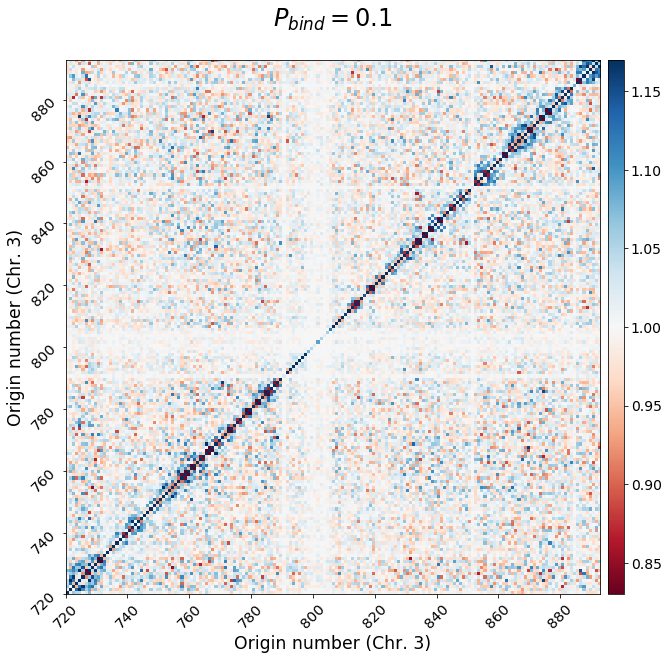

In [48]:
lineweight = 1

fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
mat = ax.matshow(concur_matrix[720:893, 720:893], cmap='RdBu', interpolation='nearest', vmin=0.83, vmax=1.17, origin='lower',extent=[0,173,0,173])

ax.xaxis.tick_bottom()
ax.set_xticks(np.arange(0, 173, 20));
ax.set_yticks(np.arange(0, 173, 20));
ax.set_xticklabels(np.arange(720, 893, 20), size='x-large', rotation=45);
ax.set_yticklabels(np.arange(720, 893, 20), size='x-large', rotation=45);
ax.set_xlabel('Origin number (Chr. 3)', size='xx-large')
ax.set_ylabel('Origin number (Chr. 3)', size='xx-large')
ax.set_title('$P_{{bind}} = 0.1$', size=24)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.1)
cbar = fig.colorbar(mat, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=14)
plt.savefig(savedir + '/concurrence_P0.1.pdf', bbox_inches='tight', dpi=1000)
plt.show()

In [49]:
neighborRange = 10
neighbors1 = []
for i in range(len(concur_matrix)):
    for n in range(-neighborRange, neighborRange):
        if i + n >= 0 and i + n < len(concur_matrix):
            neighbors1.append([abs(n), concur_matrix[i][i + n], 1])

In [50]:
neighborRange = 20
neighbors = [[] for i in range(neighborRange+1)]
for i in range(len(concur_matrix)):
    for n in range(-neighborRange, neighborRange):
        if i + n >= 0 and i + n < len(concur_matrix):
            neighbors[abs(n)].append(concur_matrix[i][i + n])
neighborMeans = [np.mean(neighbors[i]) for i in range(len(neighbors))]
neighborErrors = [np.std(neighbors[i]) for i in range(len(neighbors))]
meanConcurrence = np.mean([item for sublist in concur_matrix for item in sublist])

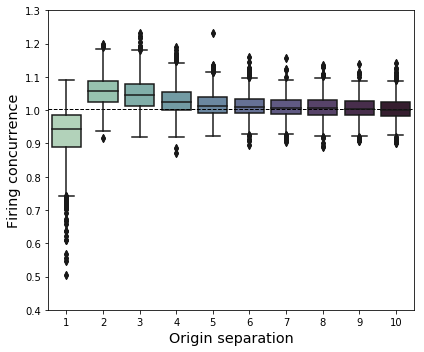

In [51]:
plotFile = savedir + r'/concurrence-boxplots-P0.1.pdf'
ax = plt.figure(figsize=(6,5)).gca()
ax.set_xlabel('Origin separation', size='x-large')
ax.set_ylabel('Firing concurrence', size='x-large')
ax.axhline(meanConcurrence, linestyle='--', linewidth=1, color='black')
bp = sns.boxplot(data=[n for n in neighbors], palette=sns.cubehelix_palette(11, start=-2.1, rot=-.8))
ax.set_xlim(0.5, 10.5)
ax.set_ylim(0.4, 1.3)
plt.tight_layout()
plt.savefig(plotFile, bbox_inches='tight')
plt.show()

### Low binding probability
<a id='lobind'></a>

[Return to top](#top)

In [52]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
oriTimesFile = basedir + r'/Simulations/runB/out/SIM_N150_D0.5_R0.025_P0.0005_A0.01_firingTimes.csv'
df = pd.read_csv(oriTimesFile)
del df['STRUCTURE']
del df['ITERATION']

In [53]:
firing = np.array(df)
nsim = firing.shape[0]
firing[np.nonzero(firing)] = 1
concur1 = np.reshape(firing, (nsim, 893, 1))
concur2 = np.reshape(firing, (nsim, 1, 893))

# Concurrence matrix (both firing or none firing)
contot_matrix = (np.sum(concur1, axis=0) * np.sum(concur2, axis=0) + 
                np.sum(1-concur1, axis=0) * np.sum(1-concur2, axis=0))
concur_matrix = concur1 * concur2 + (1-concur1) * (1-concur2)
concur_matrix = np.sum(concur_matrix, axis=0)
concur_matrix = nsim * concur_matrix / contot_matrix

# Competition matrix (one firing but not the other)
#comtot_matrix = (np.sum(concur1, axis=0) * np.sum(1-concur2, axis=0) + 
#                np.sum(concur2, axis=0) * np.sum(1-concur1, axis=0))
#competition_matrix = concur1 * (1 - concur2) + concur2 * (1 - concur1)
#competition_matrix = np.sum(noncon_matrix, axis=0)
#competition_matrix = nsim * competition_matrix / comtot_matrix

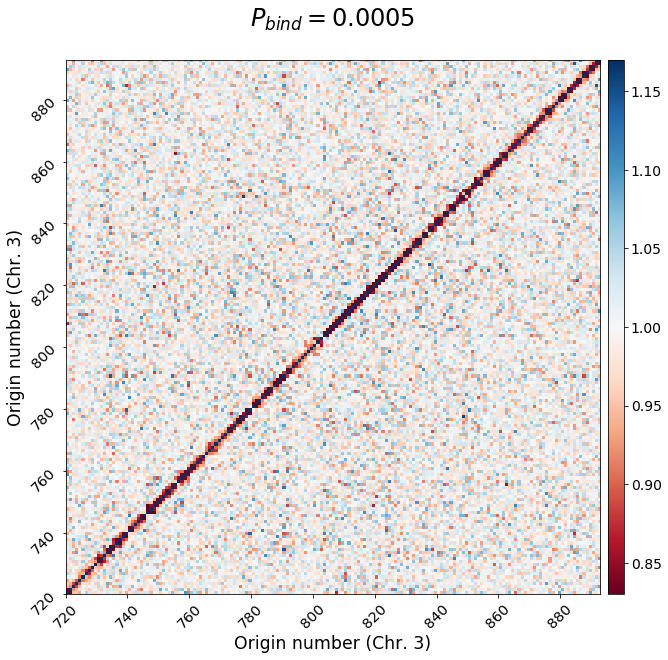

In [54]:
lineweight = 1

fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
mat = ax.matshow(concur_matrix[720:893, 720:893], cmap='RdBu', interpolation='nearest', vmin=0.83, vmax=1.17, origin='lower',extent=[0,173,0,173])

ax.xaxis.tick_bottom()
ax.set_xticks(np.arange(0, 173, 20));
ax.set_yticks(np.arange(0, 173, 20));
ax.set_xticklabels(np.arange(720, 893, 20), size='x-large', rotation=45);
ax.set_yticklabels(np.arange(720, 893, 20), size='x-large', rotation=45);
ax.set_xlabel('Origin number (Chr. 3)', size='xx-large')
ax.set_ylabel('Origin number (Chr. 3)', size='xx-large')
ax.set_title('$P_{{bind}} = 0.0005$', size=24)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.1)
cbar = fig.colorbar(mat, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=14)
plt.savefig(savedir + '/concurrence_P0.0005.pdf', bbox_inches='tight', dpi=1000)
plt.show()

In [55]:
neighborRange = 10
neighbors2 = []
for i in range(len(concur_matrix)):
    for n in range(-neighborRange, neighborRange):
        if i + n >= 0 and i + n < len(concur_matrix):
            neighbors2.append([abs(n), concur_matrix[i][i + n], 2])

In [56]:
neighborRange = 20
neighbors = [[] for i in range(neighborRange+1)]
for i in range(len(concur_matrix)):
    for n in range(-neighborRange, neighborRange):
        if i + n >= 0 and i + n < len(concur_matrix):
            neighbors[abs(n)].append(concur_matrix[i][i + n])
neighborMeans = [np.mean(neighbors[i]) for i in range(len(neighbors))]
neighborErrors = [np.std(neighbors[i]) for i in range(len(neighbors))]
meanConcurrence = np.mean([item for sublist in concur_matrix for item in sublist])

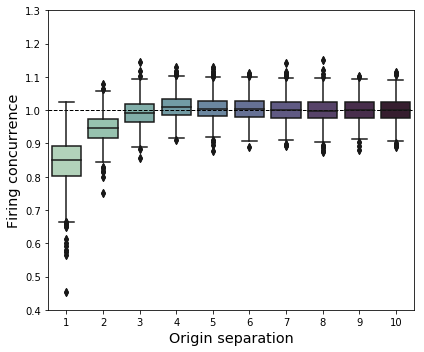

In [57]:
plotFile = savedir + r'/concurrence-boxplots-P0.0005.pdf'
ax = plt.figure(figsize=(6,5)).gca()
ax.set_xlabel('Origin separation', size='x-large')
ax.set_ylabel('Firing concurrence', size='x-large')
ax.axhline(meanConcurrence, linestyle='--', linewidth=1, color='black')
bp = sns.boxplot(data=[n for n in neighbors], palette=sns.cubehelix_palette(11, start=-2.1, rot=-.8))
ax.set_xlim(0.5, 10.5)
ax.set_ylim(0.4, 1.3)
plt.tight_layout()
plt.savefig(plotFile, bbox_inches='tight')
plt.show()

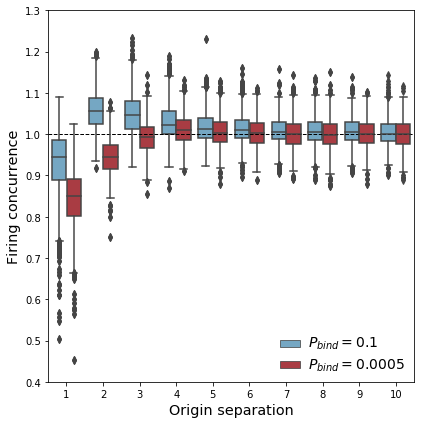

In [58]:
neighborData = pd.DataFrame(neighbors1+neighbors2, columns=['N', 'CON', 'HUE'])
plotFile = savedir + r'/concurrence-boxplots-combined.pdf'

ax = plt.figure(figsize=(6,6)).gca()
ax.axhline(1, linestyle='--', linewidth=1, color='black')
bp = sns.boxplot(x="N", y="CON", hue="HUE", data=neighborData, palette=[(0.4085351787773935, 0.6687427912341408, 0.8145328719723184), (0.7340253748558246, 0.16608996539792387, 0.20261437908496732)])
ax.set_xlabel('Origin separation', size='x-large')
ax.set_ylabel('Firing concurrence', size='x-large')
plt.legend(loc='lower right')
bp.legend_.set_title(None)
bp.legend_.set_frame_on(False)
plt.setp(ax.get_legend().get_texts(), fontsize='14')# replace labels
new_labels = ['$P_{{bind}} = 0.1$', '$P_{{bind}} = 0.0005$']
for t, l in zip(bp.legend_.texts, new_labels): t.set_text(l)
ax.set_xlim(0.5, 10.5)
ax.set_ylim(0.4, 1.3)
plt.tight_layout()
plt.savefig(plotFile, bbox_inches='tight')